Bagus Wicaksono Nurjayanto/1301194280/IF42GAB03

visualisasi geospatial yang menunjukkan sebaran kasus positif COVID19 di Indonesia per tanggal 1 Mei 2021 sampai tanggal 21 Mei 2022, menggunakan Api Connect dari https://data.covid19.go.id/

In [ ]:
#pip install geoplot

In [2]:
import requests
import imageio
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import datetime
import pathlib

from IPython.display import Image
from matplotlib import cm
from tqdm import tqdm

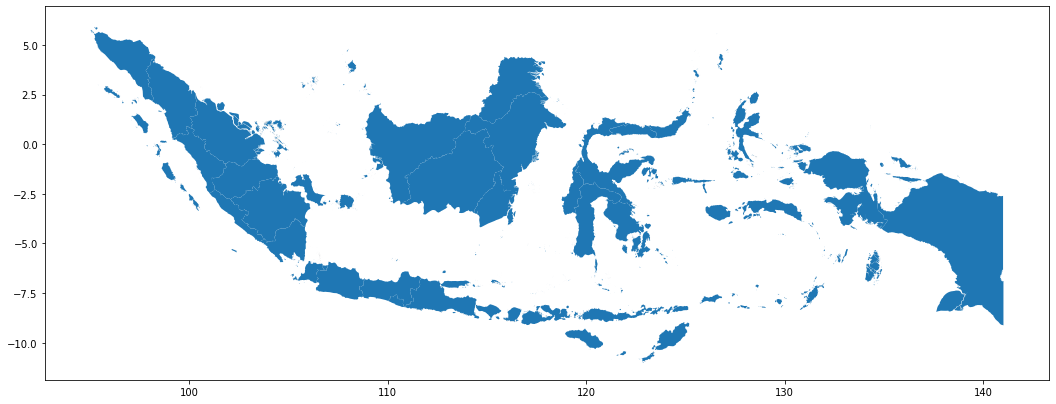

In [3]:
indonesia = gpd.read_file("Maps/Batas Provinsi.shp")
indonesia.plot(figsize=(18, 16))

In [4]:
#URL = ('https://data.covid19.go.id/public/api/prov.json')
#df = pd.read_json(URL)
#df

In [5]:
province = list(indonesia['Provinsi'])

province_u = lambda x: x.replace(' ', '_')
province_u = list(map(province_u, province))

In [6]:
dataset_pure = []

for i in tqdm(range(len(province))):
    response = requests.get(f'https://data.covid19.go.id/public/api/prov_detail_{province_u[i]}.json')
    response = response.json().get('list_perkembangan')

    dataset_pure.append([province[i], response])

100%|██████████| 34/34 [00:10<00:00,  3.40it/s]


In [7]:
dataset = dataset_pure.copy()
df_list = []

for i in range(len(dataset)):
    for j in range(len(dataset[i][1])): 
        dataset[i][1][j]['PROVINSI'] = dataset[i][0]

    df_list.append(pd.DataFrame(dataset[i][1]))    

df = pd.concat(df_list)

In [8]:
def convert_timestamp(time):
    return datetime.datetime.fromtimestamp(time / 1000).date()

df['tanggal'] = df['tanggal'].apply(convert_timestamp)

start = pd.to_datetime("2021-05-01")
end = pd.Timestamp('today').date()

df = df.loc[(df['tanggal'] >= start) & (df['tanggal'] <= end)]
df.tail(5)

/usr/local/lib/python3.7/dist-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


,tanggal,KASUS,MENINGGAL,SEMBUH,DIRAWAT_OR_ISOLASI,AKUMULASI_KASUS,AKUMULASI_SEMBUH,AKUMULASI_MENINGGAL,AKUMULASI_DIRAWAT_OR_ISOLASI,PROVINSI
791,2022-05-10,1,0,0,1,25583,25001,566,16,SULAWESI TENGGARA
792,2022-05-11,1,0,0,1,25584,25001,566,17,SULAWESI TENGGARA
793,2022-05-12,0,0,0,0,25584,25001,566,17,SULAWESI TENGGARA
794,2022-05-13,0,0,0,0,25584,25001,566,17,SULAWESI TENGGARA
795,2022-05-14,3,0,0,3,25587,25001,566,20,SULAWESI TENGGARA


In [9]:
df_covid_indonesia = indonesia.set_index('Provinsi').join(df.set_index('PROVINSI'))
df_covid_indonesia.head()

,No,Kode_Prov,geometry,tanggal,KASUS,MENINGGAL,SEMBUH,DIRAWAT_OR_ISOLASI,AKUMULASI_KASUS,AKUMULASI_SEMBUH,AKUMULASI_MENINGGAL,AKUMULASI_DIRAWAT_OR_ISOLASI
ACEH,1.0,11,"MULTIPOLYGON (((98.07694 2.57227, 98.08125 2.5...",2021-05-01,124,2,118,4,11169,9727,441,1001
ACEH,1.0,11,"MULTIPOLYGON (((98.07694 2.57227, 98.08125 2.5...",2021-05-02,68,7,52,9,11237,9779,448,1010
ACEH,1.0,11,"MULTIPOLYGON (((98.07694 2.57227, 98.08125 2.5...",2021-05-03,56,1,14,41,11293,9793,449,1051
ACEH,1.0,11,"MULTIPOLYGON (((98.07694 2.57227, 98.08125 2.5...",2021-05-04,98,5,9,84,11391,9802,454,1135
ACEH,1.0,11,"MULTIPOLYGON (((98.07694 2.57227, 98.08125 2.5...",2021-05-05,91,6,18,67,11482,9820,460,1202


In [10]:
def save_plot(anim_path, variable, date, zone = [], title = 'Setiap Provinsi Di Indonesia', range_case = 6):  
   
    df_covid = df_covid_indonesia.loc[df_covid_indonesia['tanggal'] == pd.to_datetime(date)]
    
    if len(zone) != 0:
       if len(zone) == 4:
          range_case = 4

       df_covid = df_covid_indonesia.loc[zone]
       df_covid = df_covid.loc[df_covid['tanggal'] == pd.to_datetime(date)]

    style = cm.get_cmap('Dark2', range_case)

    min_var = min(df_covid['KASUS'])
    max_var = max(df_covid['KASUS'])

    min_bar = int(np.floor(min_var))           
    max_bar = int(np.ceil(max_var))  

    sm = plt.cm.ScalarMappable(
         cmap=style,
         norm = plt.Normalize(
             vmin=min_var,
            vmax=max_var
    ))

    fig, ax = plt.subplots(1, figsize=(28, 8))
    fig.set_facecolor((1, 1, 1))
    
    df_covid.plot(column=variable, linewidth=0.8, ax=ax, cmap=style, vmin=min_var, vmax=max_var)

    ticks = [min_bar, max_bar]
    for i in range(1, range_case):
        ticks.append(int(i * (max_bar - min_bar) / range_case + min_bar)  )

    cbar = fig.colorbar(sm, pad=0.015)
    cbar.set_ticks(ticks)
    cbar.set_ticklabels(ticks)
    
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    filename = f'{anim_path}/{date}.png'

    date = datetime.datetime.strptime(date, '%Y-%m-%d')
    date = date.strftime("%d-%m-%Y")

    plt.title(f'Kasus Harian COVID-19 {title} Tanggal {date}', fontsize=16, pad=16)
    plt.savefig(filename, bbox_inches="tight", pad_inches=0.1)
    plt.close(fig)

    return filename


In [11]:
date_range = [d.strftime('%Y-%m-%d') for d in pd.date_range(start, "2022-05-21")]
date_range[0:5]

['2021-05-01', '2021-05-02', '2021-05-03', '2021-05-04', '2021-05-05']

In [12]:
animation_path = pathlib.Path("animation/")
animation_path.mkdir(parents=True, exist_ok=True)

In [ ]:
image_files_all = []
for i in tqdm(range(len(date_range))):
    image_files_all.append(save_plot(animation_path, 'KASUS', date_range[i]))

In [15]:
images = [imageio.imread(file_name) for file_name in image_files_all]
imageio.mimsave("covid.gif", images, fps=2)
Image(open('covid.gif', 'rb').read())

Animasinya tidak bisa muncul karena internet saya yang jelek dan tidak bisa load .gif nya :)

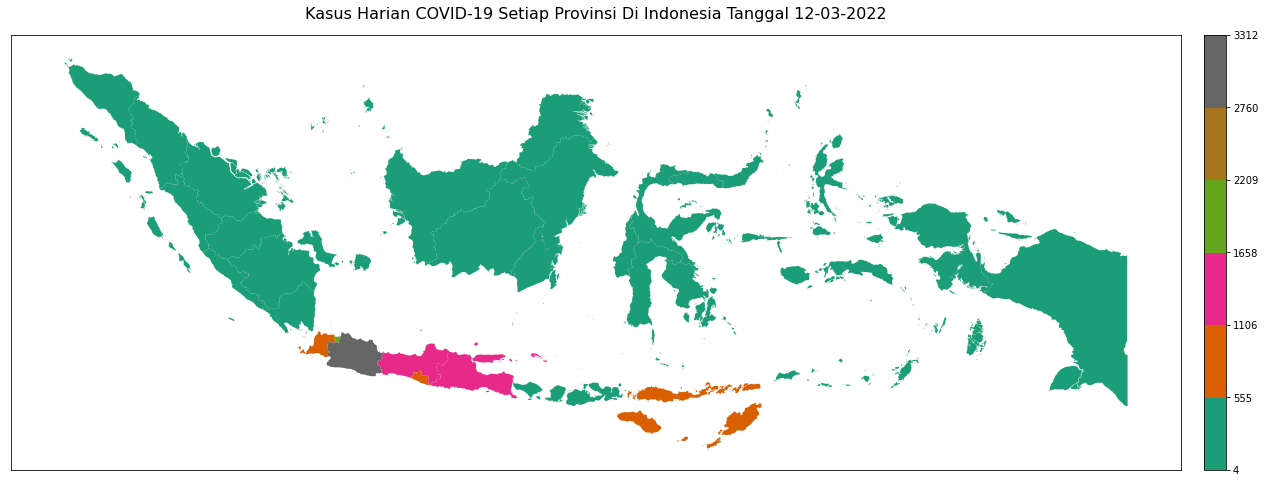

In [18]:
Image(open("animation/2022-03-12.png", 'rb').read())